In [42]:
import pandas as pd

# Load the dataset
data = pd.read_csv("customer_shopping_data.csv")

# Overview of the data
print(data.head())
print(data.info())
print(data.describe())

  invoice_no customer_id  gender  age  category  quantity    price  \
0    I138884     C241288  Female   28  Clothing         5  1500.40   
1    I317333     C111565    Male   21     Shoes         3  1800.51   
2    I127801     C266599    Male   20  Clothing         1   300.08   
3    I173702     C988172  Female   66     Shoes         5  3000.85   
4    I337046     C189076  Female   53     Books         4    60.60   

  payment_method invoice_date   shopping_mall  
0    Credit Card     5/8/2022          Kanyon  
1     Debit Card   12/12/2021  Forum Istanbul  
2           Cash    9/11/2021       Metrocity  
3    Credit Card   16/05/2021    Metropol AVM  
4           Cash   24/10/2021          Kanyon  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99457 entries, 0 to 99456
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   invoice_no      99457 non-null  object 
 1   customer_id     99457 non-null  object 
 2

In [44]:
# Check for missing values
print(data.isnull().sum())

# Handle missing values (example)
data['customer_id'] = data['customer_id'].fillna('Unknown')
data = data.dropna(subset=['price', 'quantity'])  # Drop rows with critical missing values

invoice_no        0
customer_id       0
gender            0
age               0
category          0
quantity          0
price             0
payment_method    0
invoice_date      0
shopping_mall     0
dtype: int64


In [50]:
# Convert invoice_date to datetime
#data['invoice_date'] = pd.to_datetime(data['invoice_date'])

# Ensure numeric columns are in the right format
#data['price'] = pd.to_numeric(data['price'], errors='coerce')
#data['quantity'] = pd.to_numeric(data['quantity'], errors='coerce')

In [52]:
# Convert invoice_date to datetime with explicit format
data['invoice_date'] = pd.to_datetime(data['invoice_date'], format='%d/%m/%Y')

# Check the result
print(data['invoice_date'].head())

0   2022-08-05
1   2021-12-12
2   2021-11-09
3   2021-05-16
4   2021-10-24
Name: invoice_date, dtype: datetime64[ns]


In [54]:
# Add a revenue column
data['revenue'] = data['price'] * data['quantity']

# Total revenue
total_revenue = data['revenue'].sum()
print(f"Total Revenue: {total_revenue} TL")

Total Revenue: 251505794.25000003 TL


In [56]:
# Revenue by category
category_revenue = data.groupby('category')['revenue'].sum().reset_index().sort_values(by='revenue', ascending=False)

print(category_revenue)

          category       revenue
1         Clothing  1.139968e+08
4            Shoes  6.655345e+07
6       Technology  5.786235e+07
2        Cosmetics  6.792863e+06
7             Toys  3.980426e+06
3  Food & Beverage  8.495351e+05
0            Books  8.345529e+05
5         Souvenir  6.358247e+05


In [58]:
# Average revenue by gender
gender_revenue = data.groupby('gender')['revenue'].mean()

# Revenue by age groups
data['age_group'] = pd.cut(data['age'], bins=[0, 18, 30, 50, 100], labels=['<18', '18-30', '30-50', '50+'])
age_group_revenue = data.groupby('age_group', observed=False)['revenue'].mean()

print(gender_revenue)
print(age_group_revenue)

gender
Female    2525.253623
Male      2534.050237
Name: revenue, dtype: float64
age_group
<18      2384.880835
18-30    2530.184722
30-50    2534.442761
50+      2529.241080
Name: revenue, dtype: float64


In [62]:
mall_revenue = data.groupby('shopping_mall')['revenue'].sum().reset_index().sort_values(by='revenue', ascending=False)
print(mall_revenue)

       shopping_mall      revenue
5   Mall of Istanbul  50872481.68
4             Kanyon  50554231.10
6          Metrocity  37302787.33
7       Metropol AVM  25379913.19
3       Istinye Park  24618827.68
9       Zorlu Center  12901053.82
0        Cevahir AVM  12645138.20
8     Viaport Outlet  12521339.72
1  Emaar Square Mall  12406100.29
2     Forum Istanbul  12303921.24


In [64]:
payment_method_usage = data['payment_method'].value_counts()
print(payment_method_usage)

payment_method
Cash           44447
Credit Card    34931
Debit Card     20079
Name: count, dtype: int64


In [66]:
# Calculate RFM metrics
rfm = data.groupby('customer_id').agg({
    'invoice_date': lambda x: (pd.Timestamp.now() - x.max()).days,  # Recency
    'invoice_no': 'count',  # Frequency
    'revenue': 'sum'  # Monetary
}).rename(columns={'invoice_date': 'recency', 'invoice_no': 'frequency', 'revenue': 'monetary'})

print(rfm.head())

             recency  frequency  monetary
customer_id                              
C100004         1147          1   7502.00
C100005          685          1   2400.68
C100006          777          1    322.56
C100012         1250          1    130.75
C100019         1271          1     35.84


In [30]:
data['month'] = data['invoice_date'].dt.to_period('M')
monthly_revenue = data.groupby('month')['revenue'].sum()

print(monthly_revenue)

month
2021-01     9641614.62
2021-02     8772315.22
2021-03     9455359.38
2021-04     9389541.54
2021-05     9771756.97
2021-06     9286271.35
2021-07    10311119.68
2021-08     9630655.70
2021-09     9188165.62
2021-10    10263015.06
2021-11     9265555.29
2021-12     9585200.16
2022-01     9764311.14
2022-02     8344111.92
2022-03     9986685.16
2022-04     9326144.44
2022-05     9947574.13
2022-06     9647503.95
2022-07    10067602.95
2022-08     9651705.59
2022-09     9607629.29
2022-10    10282075.37
2022-11     8941584.66
2022-12     9869885.48
2023-01     9485599.83
2023-02     9508662.96
2023-03     2514146.79
Freq: M, Name: revenue, dtype: float64


In [67]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Scale RFM data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['recency', 'frequency', 'monetary']])

# Apply K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['cluster'] = kmeans.fit_predict(rfm_scaled)

print(rfm['cluster'].value_counts())

cluster
0    44098
2    43997
1    11362
Name: count, dtype: int64


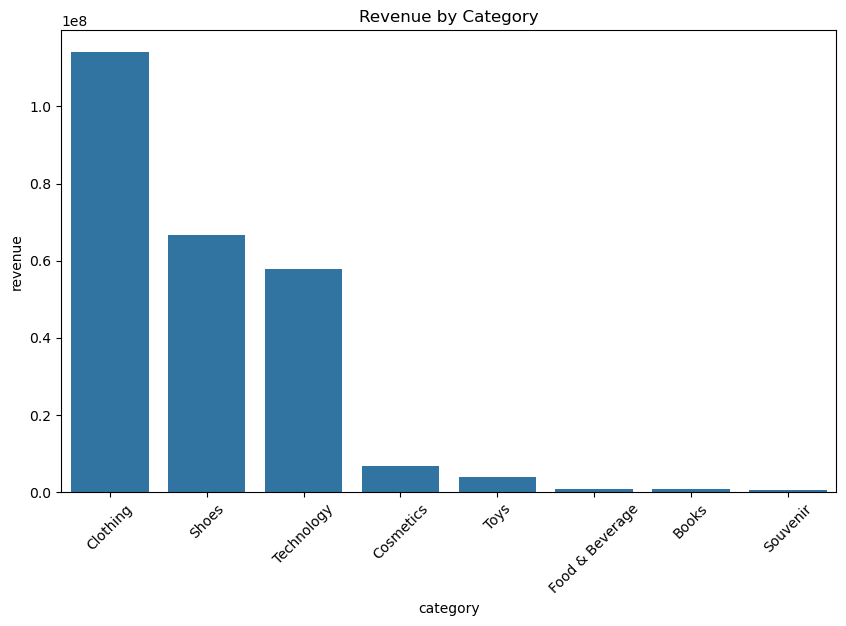

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=category_revenue, x='category', y='revenue')
plt.title("Revenue by Category")
plt.xticks(rotation=45)
plt.show()

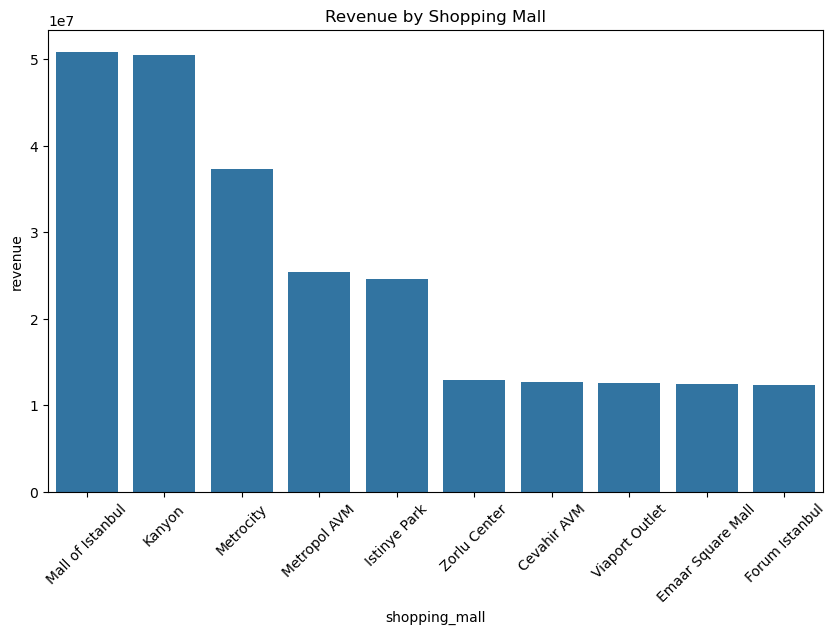

In [68]:
plt.figure(figsize=(10, 6))
sns.barplot(data=mall_revenue, x='shopping_mall', y='revenue')
plt.title("Revenue by Shopping Mall")
plt.xticks(rotation=45)
plt.show()

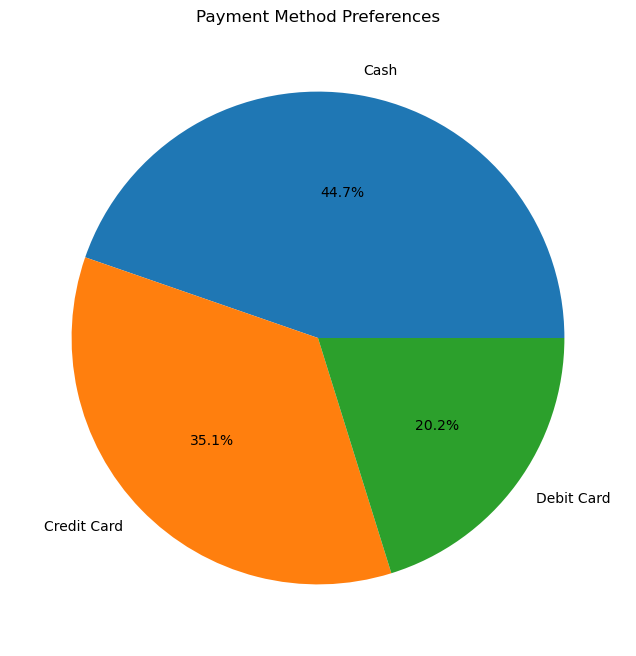

In [72]:
payment_method_usage.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8))
plt.title("Payment Method Preferences")
plt.ylabel("")
plt.show()

In [ ]:
# Insights
# 1. Top Categories: "Clothing" and "Shoes" generate the highest revenue.
# 2. Shopping Mall Performance: "Mall of Istanbul" generates the highest revenue, while "Forum Istanbul" has untapped potential.
# 3. Payment Methods: Credit cards are preferred; promoting credit card rewards can increase usage.

# Recommendations
# Stock popular categories more frequently (e.g., Clothing, Shoes).
# Focus on underperforming malls with targeted campaigns.